In [57]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import pearsonr
from scipy.stats import chisquare
from mpl_toolkits.mplot3d import Axes3D


Correlation coefficient: 0.501
P-value: 3.521e-03


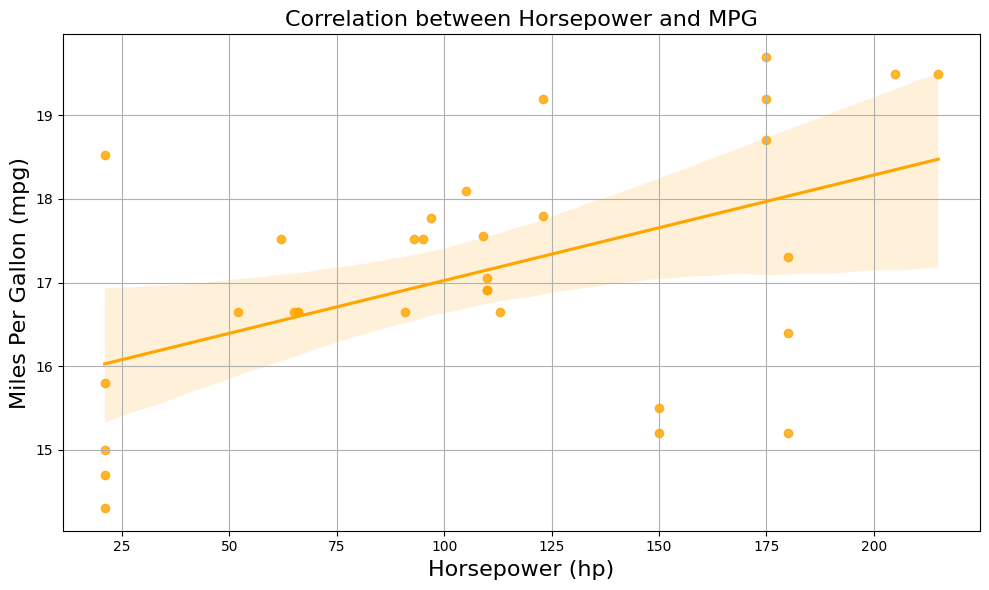

In [58]:
#Analyze the given dataset

# Load CSV file
df = pd.read_csv("mtcars_manipulated.csv")  # Replace with your actual CSV filename

# Extract variables
x = df['hp']
y = df['mpg']

# Compute Pearson correlation and p-value
corr_coeff, p_value = pearsonr(x, y)
print(f"Correlation coefficient: {corr_coeff:.3f}")
print(f"P-value: {p_value:.3e}")

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y, scatter_kws={'color': 'orange'}, line_kws={'color': 'orange'})
plt.title("Correlation between Horsepower and MPG", fontsize=16)
plt.xlabel("Horsepower (hp)", fontsize=16)
plt.ylabel("Miles Per Gallon (mpg)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# Function to extract first digit
def extract_first_digit(series):
    def first_digit(x):
        try:
            x = abs(float(x))
            while x >= 10:
                x //= 10
            while x < 1 and x != 0:
                x *= 10
            return int(str(x)[0])
        except:
            return np.nan
    return series.dropna().apply(first_digit)

# Benford expected distribution
def benford_expected_distribution():
    return np.array([math.log10(1 + 1/d) for d in range(1, 10)])

# Function to perform Benford analysis
def perform_benford_test(series, label):
    first_digits = extract_first_digit(series)
    observed_counts = first_digits.value_counts().sort_index()
    observed = observed_counts.reindex(range(1, 10), fill_value=0).values
    expected = benford_expected_distribution() * observed.sum()

    # Chi-square and p-value
    chi2, p = chisquare(f_obs=observed, f_exp=expected)
    
    # Plotting
    plt.figure(figsize=(5, 3))
    plt.bar(range(1, 10), observed / observed.sum(), alpha=0.6, label="Observed", color='orange')
    plt.plot(range(1, 10), benford_expected_distribution(), 'ro-', label="Benford")
    plt.title(f"Benford Analysis: {label}")
    plt.xlabel("Leading Digit")
    plt.ylabel("Frequency")
    plt.xticks(range(1, 10))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print(f"--- {label.upper()} ---")
    print(f"Chi-square = {chi2:.4f}, p-value = {p:.18f}\n")
    return chi2, p


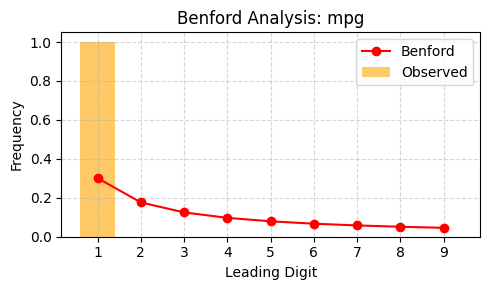

--- MPG ---
Chi-square = 74.3017, p-value = 0.000000000000680554

classified as: Benford Anomaly and Extrem


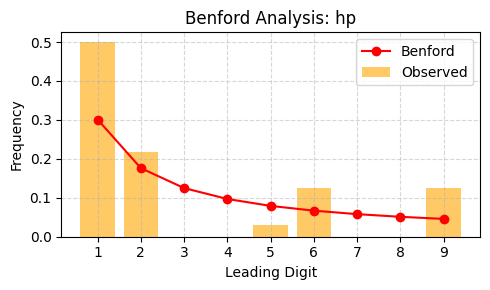

--- HP ---
Chi-square = 22.0617, p-value = 0.004802923224322200

classified as: Acceptable


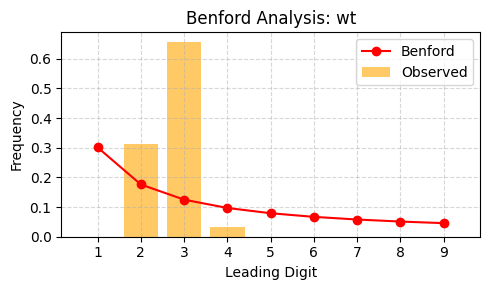

--- WT ---
Chi-square = 96.3730, p-value = 0.000000000000000023

classified as: Benford Anomaly and Extrem


In [60]:
# Apply Benford's law to specific columns
variables = ['mpg', 'hp','wt']  
results = {}

for col in columns_to_check:
    if col in df.columns:
        chi2, p = perform_benford_test(df[col], col)
        results[col] = {'chi2': chi2, 'p-value': p}
    else:
        print(f"Column '{col}' not found in dataset.")
    #Determine manipulated and extreme variable
    if chi2 > 30.58 and p < 0.0001:
        classification = "Benford Anomaly and Extrem"
    else:
        classification = "Acceptable"

    print(f"classified as: {classification}")

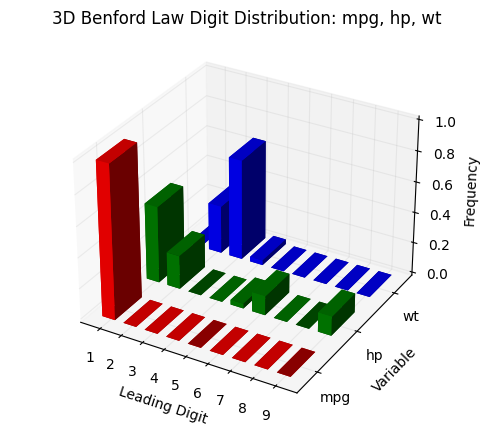

In [61]:
digit_range = np.arange(1, 10)

# --- Compute observed frequencies ---
observed_matrix = []
for var in variables:
    first_digits = extract_first_digit(df[var])
    counts = first_digits.value_counts().sort_index()
    freqs = counts.reindex(digit_range, fill_value=0) / counts.sum()
    observed_matrix.append(freqs.values)

observed_matrix = np.array(observed_matrix)

# --- 3D Bar Plot ---
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(len(digit_range))
_y = np.arange(len(variables))
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
z = np.zeros_like(x)
dz = observed_matrix.ravel()

colors = ['red', 'green', 'blue']
#bar_colors = np.array(colors * len(digit_range))
bar_colors = np.repeat(colors, len(digit_range))

ax.bar3d(x, y, z, dx=0.6, dy=0.6, dz=dz, color=bar_colors, shade=True)

# Axis settings
ax.set_xlabel('Leading Digit')
ax.set_ylabel('Variable')
ax.set_zlabel('Frequency')
ax.set_xticks(_x + 0.3)
ax.set_xticklabels(digit_range)
ax.set_yticks(np.arange(len(variables)) + 0.3)
ax.set_yticklabels(variables)
ax.xaxis._axinfo["grid"]['color'] =  (0.7, 0.7, 0.7, 0.2)  # light transparent grey
ax.yaxis._axinfo["grid"]['color'] =  (0.7, 0.7, 0.7, 0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.7, 0.7, 0.7, 0.2)

ax.set_title('        3D Benford Law Digit Distribution: mpg, hp, wt       ')

plt.tight_layout()
plt.show()